In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥1.0.2 is required
import sklearn
assert sklearn.__version__ >= "1.0.2"

# Common imports
import numpy as np
import os
import pandas as pd
import time

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=22)

In [2]:
# read data from csv file
trainset = pd.read_csv("C:/Users/21294596/OneDrive - Curtin/Coding/Phree_t1/April/Dataset_Train_Test/trainset_1.csv")
testset = pd.read_csv("C:/Users/21294596/OneDrive - Curtin/Coding/Phree_t1/April/Dataset_Train_Test/testset_1.csv")
print(trainset.shape)
print(testset.shape)

(8000, 18)
(2000, 18)


In [3]:
X_train = trainset.iloc[:, 0:11].values
y_train = trainset.iloc[:, 11:].values
X_test = testset.iloc[:, 0:11].values
y_test = testset.iloc[:, 11:].values

inputs = list(trainset.columns[0:11])
outputs = list(trainset.columns[11:])

print('Inputs: ', inputs)
print('Outputs: ', outputs)
print('X_train instances: ', X_train.shape)
print('X_test instances: ', X_test.shape)
print('y_train instances: ', y_train.shape)
print('y_test instances: ', y_test.shape)

Inputs:  ['pH', 'Mg Bound (Initial)', 'Mg Initial', 'Ca Bound (Initial)', 'Ca Initial', 'C(4) Bound (Initial)', 'C(4) Initial', 'Cl Bound (Initial)', 'Cl Initial', 'cal_ini_mol', 'dol_ini_mol']
Outputs:  ['C(4) Final', 'Ca Final', 'Mg Final', 'Cl Final', 'pH.1', 'Calcite', 'Dolomite']
X_train instances:  (8000, 11)
X_test instances:  (2000, 11)
y_train instances:  (8000, 7)
y_test instances:  (2000, 7)


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

norm_pipeline = Pipeline([
        ('minmax_scaler', MinMaxScaler((-1,1))),
    ])

X_train_norm = norm_pipeline.fit_transform(X_train)
X_test_norm = norm_pipeline.transform(X_test)

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try combinations of hyperparameters
    {'bootstrap': [True, False], 
     'n_estimators': [50, 75, 100],  
     'max_features': [0.4, 0.6, 0.8, 1.0],
     'max_depth': [10, 20, 30],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 4, 8]
    }]

# train across 3 folds
grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                           param_grid, 
                           
                           cv=3,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, 
                           verbose = 1,
                           n_jobs= -1)
start = time.time()
grid_search.fit(X_train_norm, y_train)
print("Run time = ", time.time()-start)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits
Run time =  2168.1007783412933


In [6]:
print(f"best parameters: {grid_search.best_params_}")
print(f"best score:      {-grid_search.best_score_:0.5f} (+/-{grid_search.cv_results_['std_test_score'][grid_search.best_index_]:0.5f})")

best parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 75}
best score:      0.00105 (+/-0.00012)


In [7]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df[["params", "rank_test_score", "mean_train_score", "std_train_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score
310,"{'bootstrap': True, 'max_depth': 30, 'max_feat...",1,-0.000218,0.000004,-0.001046,0.000120
199,"{'bootstrap': True, 'max_depth': 20, 'max_feat...",1,-0.000218,0.000004,-0.001046,0.000120
202,"{'bootstrap': True, 'max_depth': 20, 'max_feat...",1,-0.000218,0.000004,-0.001046,0.000120
307,"{'bootstrap': True, 'max_depth': 30, 'max_feat...",1,-0.000218,0.000004,-0.001046,0.000120
94,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",5,-0.000223,0.000005,-0.001048,0.000111
...,...,...,...,...,...,...
6,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",644,-0.003117,0.000238,-0.007378,0.000065
15,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",645,-0.003660,0.000588,-0.007688,0.000886
18,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",646,-0.003876,0.000135,-0.007759,0.000509
21,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",646,-0.003876,0.000135,-0.007759,0.000509


In [8]:
reg_best = grid_search.best_estimator_

print(grid_search.best_params_, end='\n')
print(grid_search.best_estimator_)

{'bootstrap': True, 'max_depth': 20, 'max_features': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 75}
RandomForestRegressor(max_depth=20, min_samples_leaf=2, n_estimators=75,
                      random_state=42)


In [9]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.0835011590265006 {'bootstrap': True, 'max_depth': 10, 'max_features': 0.4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
0.07932285937617088 {'bootstrap': True, 'max_depth': 10, 'max_features': 0.4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 75}
0.07829564936938953 {'bootstrap': True, 'max_depth': 10, 'max_features': 0.4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.08402543264128519 {'bootstrap': True, 'max_depth': 10, 'max_features': 0.4, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 50}
0.07907158725424032 {'bootstrap': True, 'max_depth': 10, 'max_features': 0.4, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 75}
0.07854007441393826 {'bootstrap': True, 'max_depth': 10, 'max_features': 0.4, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
0.08589394727281767 {'bootstrap': True, 'max_depth': 10, 'max_features': 0.4, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_e

In [10]:
sorted(zip(np.sqrt(-cvres["mean_test_score"]), cvres["params"]), key=lambda cvres: cvres[0], reverse=False)


[(0.0323437775936141,
  {'bootstrap': True,
   'max_depth': 20,
   'max_features': 1.0,
   'min_samples_leaf': 2,
   'min_samples_split': 2,
   'n_estimators': 75}),
 (0.0323437775936141,
  {'bootstrap': True,
   'max_depth': 20,
   'max_features': 1.0,
   'min_samples_leaf': 2,
   'min_samples_split': 4,
   'n_estimators': 75}),
 (0.0323437775936141,
  {'bootstrap': True,
   'max_depth': 30,
   'max_features': 1.0,
   'min_samples_leaf': 2,
   'min_samples_split': 2,
   'n_estimators': 75}),
 (0.0323437775936141,
  {'bootstrap': True,
   'max_depth': 30,
   'max_features': 1.0,
   'min_samples_leaf': 2,
   'min_samples_split': 4,
   'n_estimators': 75}),
 (0.032368865797877795,
  {'bootstrap': True,
   'max_depth': 10,
   'max_features': 1.0,
   'min_samples_leaf': 2,
   'min_samples_split': 2,
   'n_estimators': 75}),
 (0.032368865797877795,
  {'bootstrap': True,
   'max_depth': 10,
   'max_features': 1.0,
   'min_samples_leaf': 2,
   'min_samples_split': 4,
   'n_estimators': 75}),


In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

start = time.time()
y_train_pred = reg_best.predict(X_train_norm)
end = time.time()
print("time = ", start - end)
print()

mse = mean_squared_error(y_train, y_train_pred)
print('mse: ',mse)
rmse = np.sqrt(mse)
print('rmse: ',rmse)
mae = mean_absolute_error(y_train, y_train_pred)
print('mae: ',mae)

r2_model = r2_score(y_train, y_train_pred)
print('\nR2: ',r2_model)

time =  -0.26331400871276855

mse:  0.0001454205435149016
rmse:  0.012059044054770743
mae:  0.0013865767427566047

R2:  0.9997757925002426


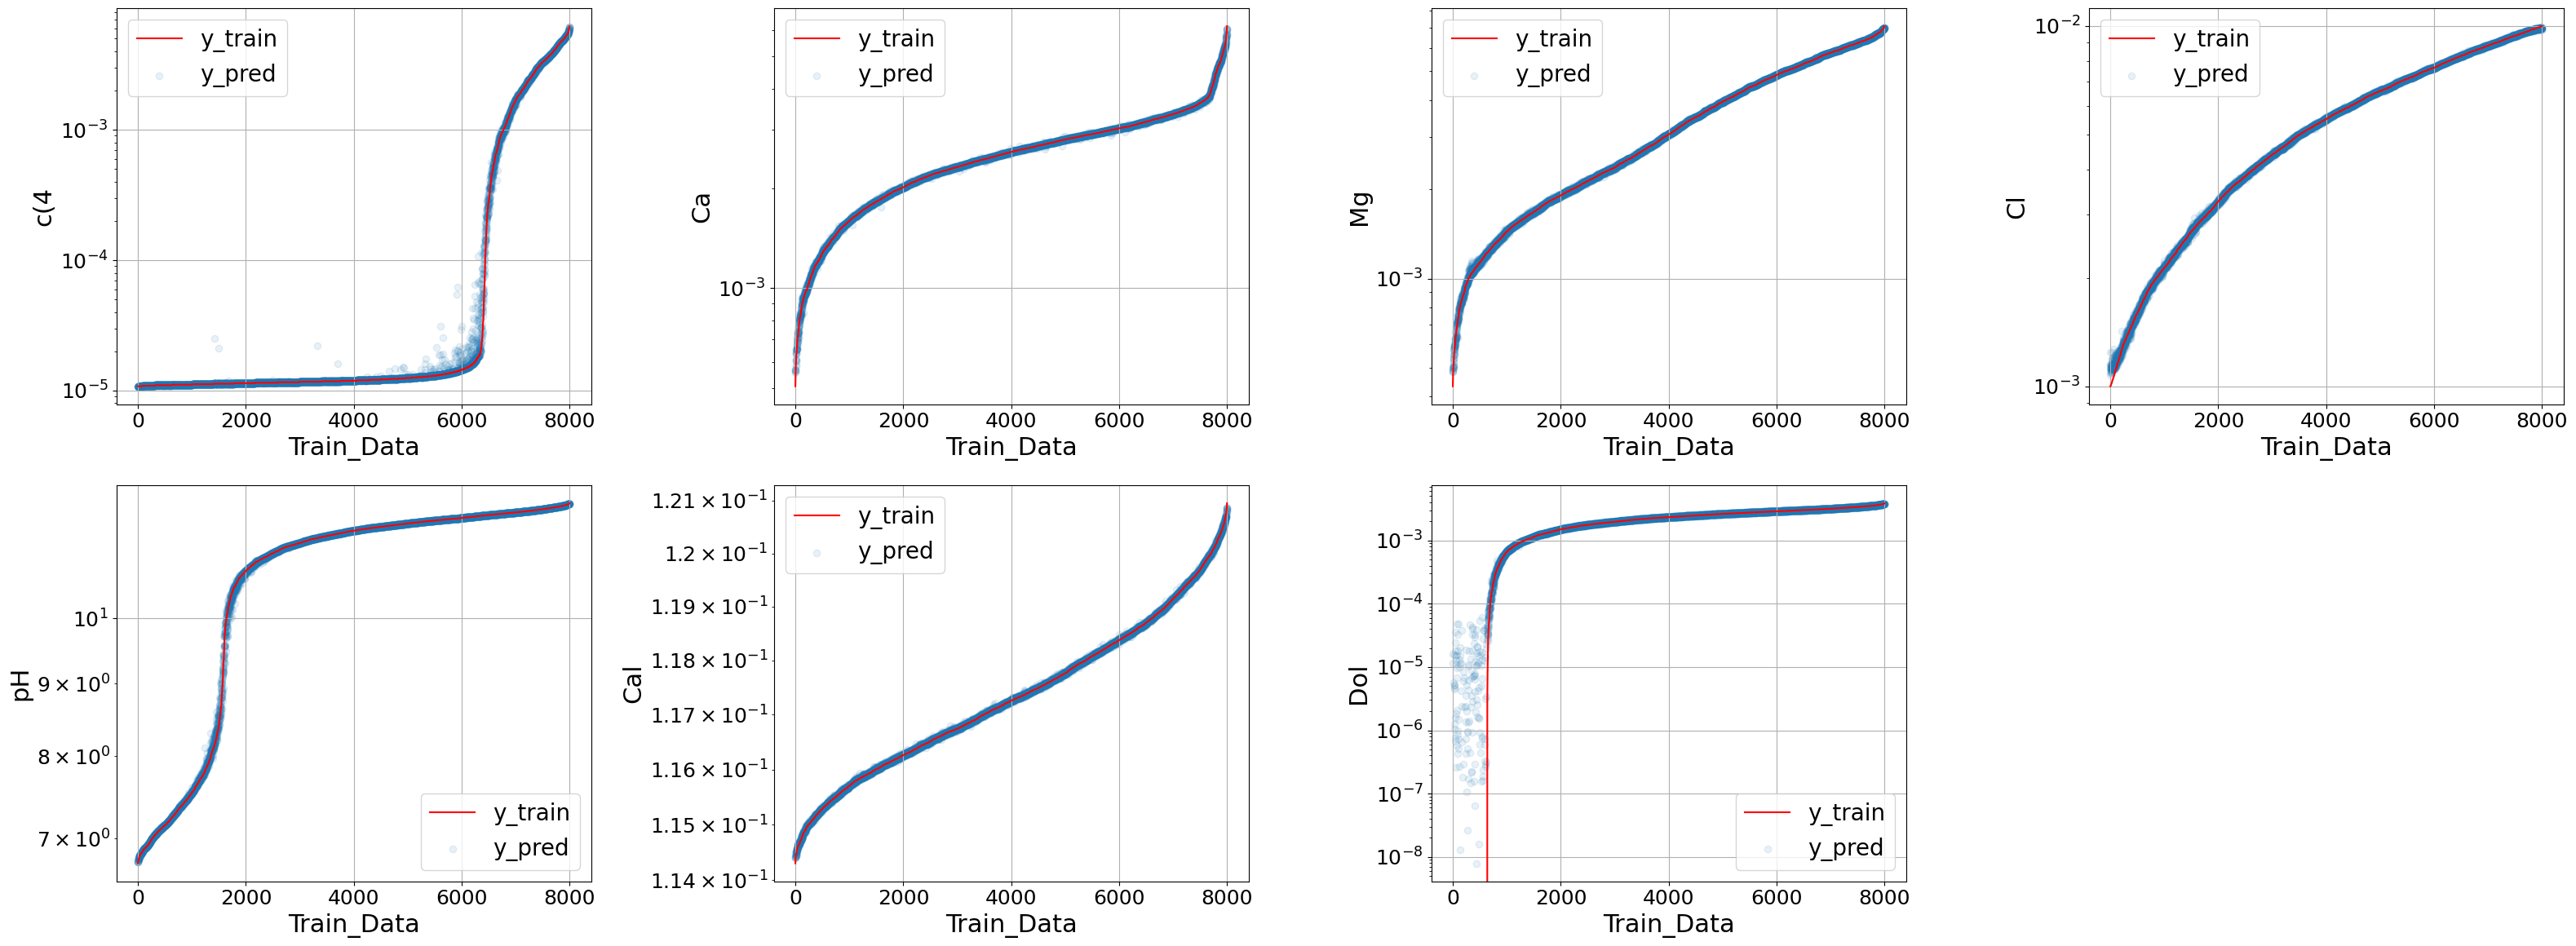

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Update font sizes
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)
mpl.rc('axes', labelsize=22)

# Assume 'outputs' is a list of output feature names
outputs = ["c(4)", "Ca", "Mg", "Cl","pH","Cal", "Dol"]  # Replace with actual feature names

num_outputs = len(outputs)  # Number of output features

# Calculate number of rows and columns for subplots
num_rows = 2
num_cols = (num_outputs + 1) // 2  # Round up to ensure enough space for all plots

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 8, num_rows * 6))

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        output_index = i * num_cols + j  # Calculate index of output feature
        if output_index < num_outputs:
            aux_train = y_train[:, output_index]
            aux_pred = y_train_pred[:, output_index]
            index = np.argsort(aux_train)
            x = range(len(index))
            ax.plot(x, aux_train[index], 'r-')
            ax.scatter(x, aux_pred[index], alpha=0.1)
            ax.legend(['y_train', 'y_pred'])
            ax.set_xlabel('Train_Data')
            ax.  set_ylabel(outputs[output_index][:3])
            ax.grid()
            ax.set_yscale('log')  # Set y-axis to log scale

# If the number of output features is odd, remove the empty subplot
if num_outputs % 2 == 1:
    fig.delaxes(axes[num_rows - 1, num_cols - 1])

plt.tight_layout()
plt.show()


In [13]:
start = time.time()
y_test_pred = reg_best.predict(X_test_norm)
end = time.time()
print("time = ", start - end)
print()

mse = mean_squared_error(y_test, y_test_pred)
print('mse: ',mse)
rmse = np.sqrt(mse)
print('rmse: ',rmse)
mae = mean_absolute_error(y_test, y_test_pred)
print('mae: ',mae)

r2_model = r2_score(y_test, y_test_pred)
print('\nR2: ',r2_model)

time =  -0.0875093936920166

mse:  0.0008434402433494274
rmse:  0.02904204268555205
mae:  0.0034532401079002133

R2:  0.99910679733794


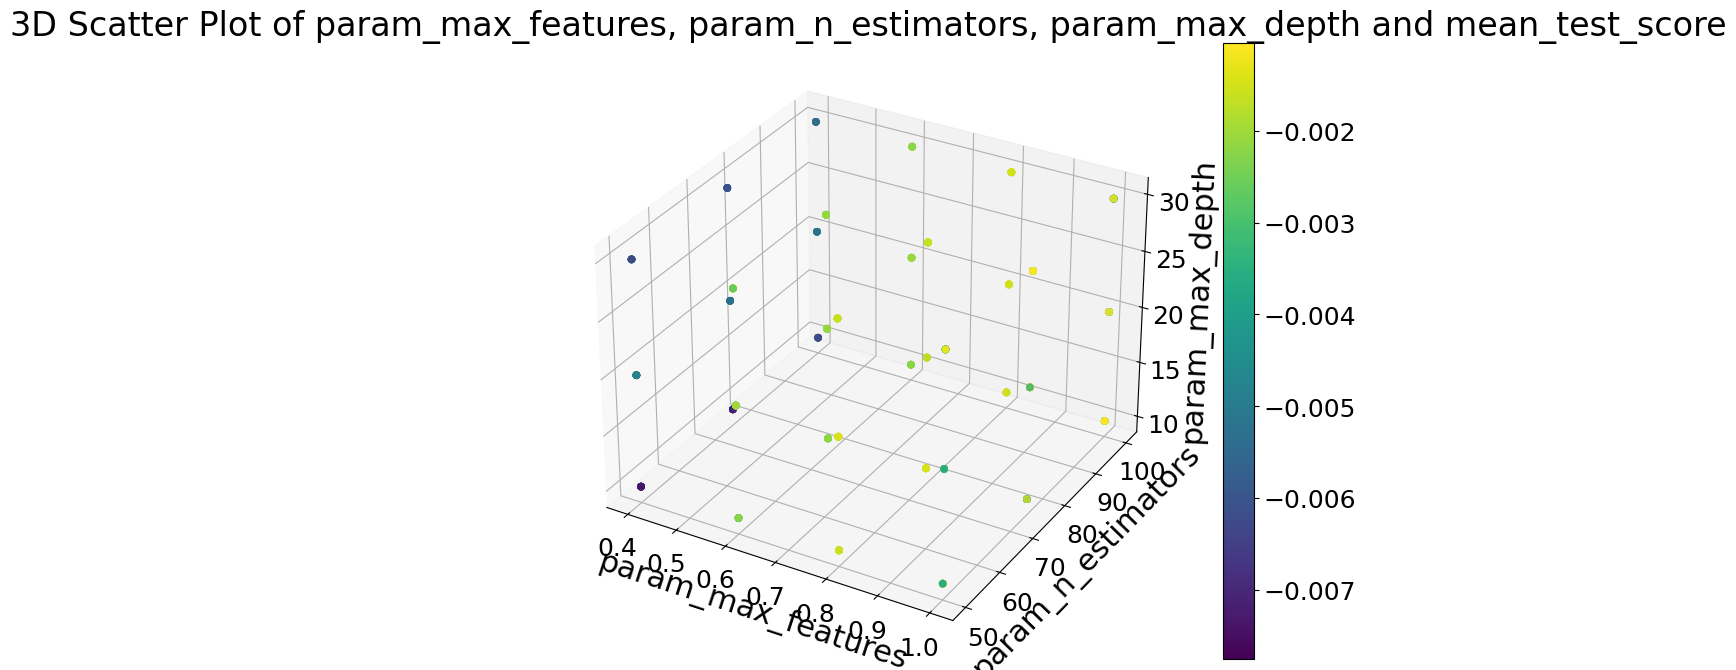

In [15]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_scatter(data, x_param, y_param, z_param, score='mean_test_score'):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    sc = ax.scatter(data[x_param], data[y_param], data[z_param], c=data[score], cmap='viridis', marker='o')
    ax.set_xlabel(x_param)
    ax.set_ylabel(y_param)
    ax.set_zlabel(z_param)
    plt.title(f'3D Scatter Plot of {x_param}, {y_param}, {z_param} and {score}')
    plt.colorbar(sc)
    plt.show()

# Example: 3D scatter plot of max_features, max_depth, and min_samples_leaf
plot_3d_scatter(results_df, 'param_max_features', 'param_n_estimators', 'param_max_depth', score='mean_test_score')

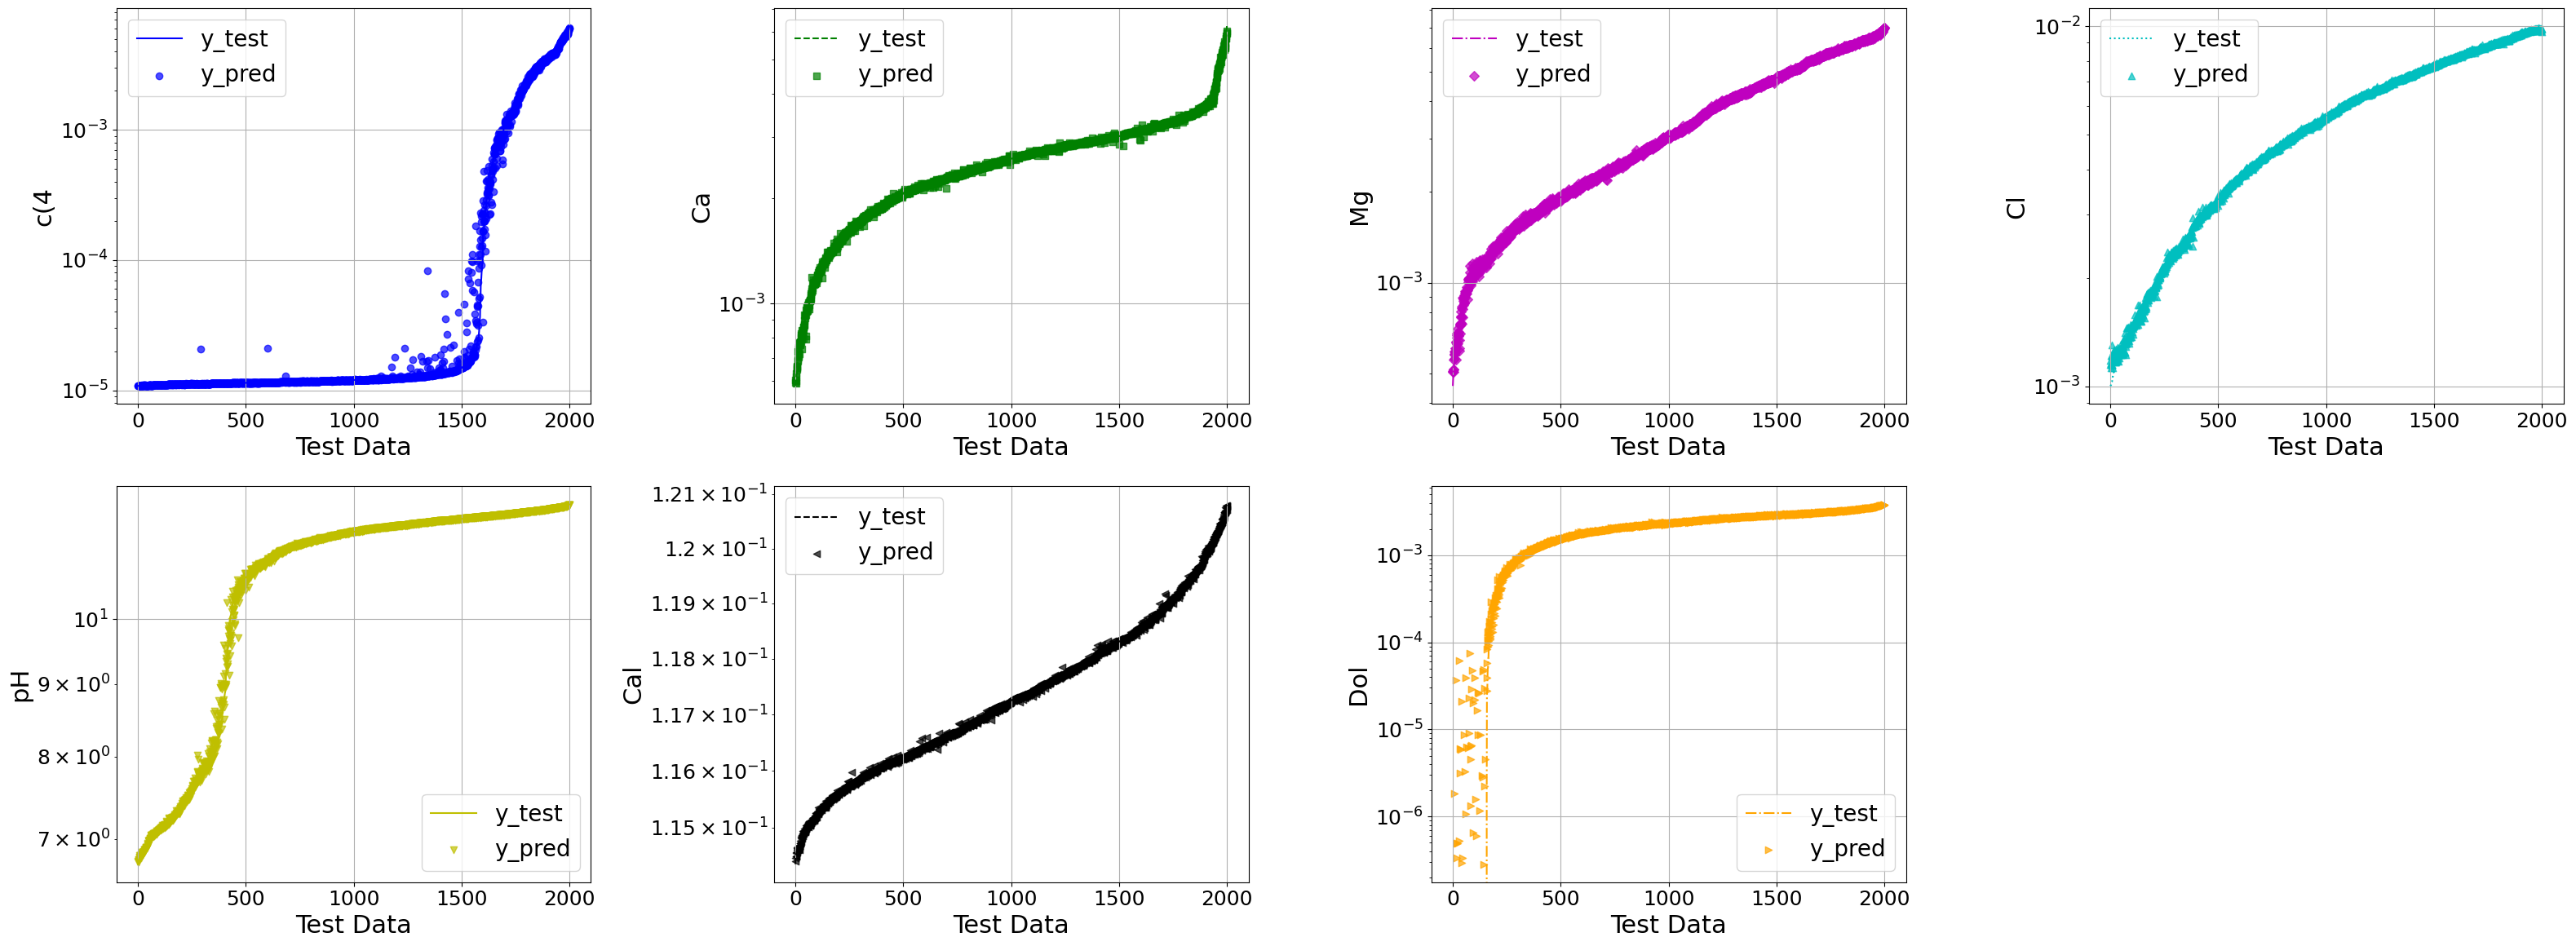

In [16]:
# Testing Data Accuracy
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Update font sizes
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)
mpl.rc('axes', labelsize=22)

# Assume 'outputs' is a list of output feature names
outputs = ["c(4)", "Ca", "Mg", "Cl", "pH", "Cal", "Dol"]  # Replace with actual feature names

num_outputs = len(outputs)  # Number of output features

# Calculate number of rows and columns for subplots
num_rows = 2
num_cols = (num_outputs + 1) // 2  # Round up to ensure enough space for all plots

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 8, num_rows * 6))

# Define different colors, line styles, and markers
colors = ['b', 'g', 'm', 'c', 'y', 'k', 'orange']
line_styles = ['-', '--', '-.', ':', '-', '--', '-.']
markers = ['o', 's', 'D', '^', 'v', '<', '>']

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        output_index = i * num_cols + j  # Calculate index of output feature
        if output_index < num_outputs:
            aux_train = y_test[:, output_index]
            aux_pred = y_test_pred[:, output_index]
            index = np.argsort(aux_train)
            x = range(len(index))

            color = colors[output_index % len(colors)]
            line_style = line_styles[output_index % len(line_styles)]
            marker = markers[output_index % len(markers)]

            ax.plot(x, aux_train[index], line_style, color=color, label='y_test')
            ax.scatter(x, aux_pred[index], color=color, alpha=0.7, marker=marker, label='y_pred')
            ax.legend()
            ax.set_xlabel('Test Data')
            ax.set_ylabel(outputs[output_index][:3])
            ax.grid(True)
            ax.set_yscale('log')  # Set y-axis to log scale

# If the number of output features is odd, remove the empty subplot
if num_outputs % 2 == 1:
    fig.delaxes(axes[num_rows - 1, num_cols - 1])

plt.tight_layout()
plt.show()

In [17]:
 #Runtime

start = time.time()
for i in range(1000):  
    reg_best.predict(X_test_norm[0:1])
end = time.time()
print("time = ", (start - end)/1000)
print()

time =  -0.004451871633529663



In [18]:
import joblib
final_model = Pipeline([
        ("norm", norm_pipeline),
        ("reg", reg_best)
        ])

print('rmse: ', np.sqrt(mean_squared_error(y_test, final_model.predict(X_test))))
joblib.dump(final_model, "RFmodel.pkl")

rmse:  0.02904204268555205


['RFmodel.pkl']

In [19]:
import joblib
from sklearn.metrics import mean_squared_error

#joblib.dump(final_model, "DTmodel.pkl")
final_model_loaded = joblib.load("DTmodel.pkl") 

print('rmse: ', np.sqrt(mean_squared_error(y_test, final_model_loaded.predict(X_test))))

rmse:  0.048941935004476654


In [20]:
start = time.time()
final_model_loaded = joblib.load("DTmodel.pkl") 
end_load = time.time()
print('Load time = ', end_load - start)
start = time.time()
for i in range(1000):    
    y_pred = final_model_loaded.predict(X_test[0:1])
end = time.time()    
print('Prediction time 1 = ', (end - start)/1000)
start = time.time()
for i in range(1000):    
    y_pred = final_model_loaded.predict(X_test[0:1000])
end = time.time()    
print('Prediction time 1000 = ', (end - start)/1000)
start = time.time()
for i in range(1000):    
    y_pred = final_model_loaded.predict(X_test[0:10000])
end = time.time()    
print('Prediction time 10,000 = ', (end - start)/1000)

Load time =  0.004781007766723633
Prediction time 1 =  0.0004372086524963379
Prediction time 1000 =  0.0007588348388671875
Prediction time 10,000 =  0.001695310354232788


Load time =  0.0028569698333740234
Prediction time 1 =  0.00040007519721984864
Prediction time 1000 =  0.0008913354873657227
Prediction time 10000 =  0.0010883681774139405


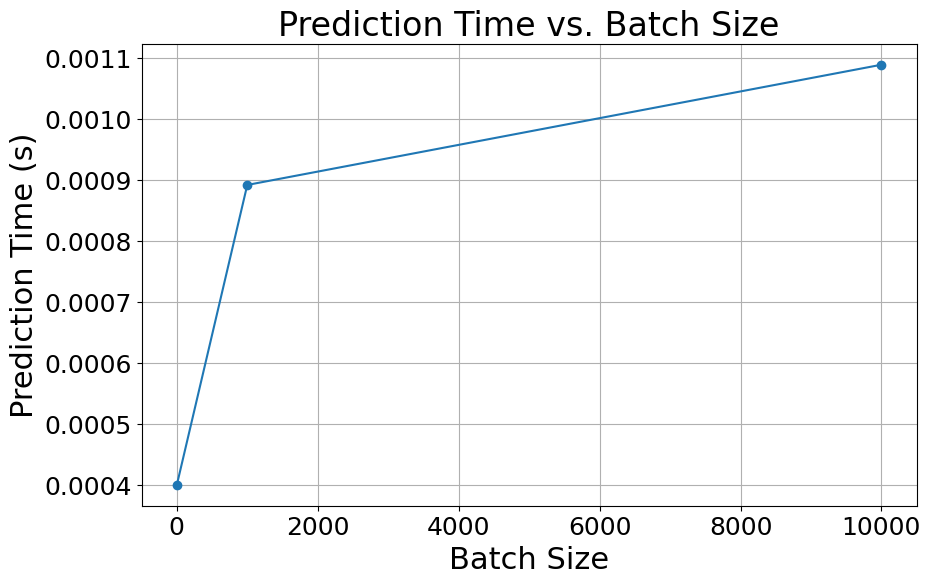

In [21]:
import time
import joblib
import matplotlib.pyplot as plt

# Load the model
start = time.time()
final_model_loaded = joblib.load("DTmodel.pkl")
end_load = time.time()
print('Load time = ', end_load - start)

# Define batch sizes
batch_sizes = [1, 1000, 10000]
prediction_times = []

# Measure prediction times for different batch sizes
for batch_size in batch_sizes:
    start = time.time()
    for _ in range(1000):
        y_pred = final_model_loaded.predict(X_test[:batch_size])
    end = time.time()
    prediction_times.append((end - start) / 1000)
    print(f'Prediction time {batch_size} = ', (end - start) / 1000)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, prediction_times, marker='o')
plt.title('Prediction Time vs. Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Prediction Time (s)')
plt.grid(True)
plt.show()